In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from tqdm import tqdm

file_path = Path('data') / 'tinyshakespeare' / 'input.txt'
with open(file_path, 'r') as f:
    text = f.read()

print(f"{len(text) = }")

len(text) = 1115394


In [17]:
chars = sorted(set(text))
print(f"{len(chars) = }")
print(repr(''.join(chars)))

len(chars) = 65
"\n !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"


In [18]:
stoi = {c: i for i, c in enumerate(chars)}
itos = {i: c for i, c in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: [itos[i] for i in l]
''.join(decode(encode('hello world')))

'hello world'

In [19]:
data = torch.tensor(encode(text))
data.shape

torch.Size([1115394])

In [20]:
idx = int(len(data) * .9)
train_data = data[:idx]
val_data   = data[idx:]

train_data.shape, val_data.shape

(torch.Size([1003854]), torch.Size([111540]))

In [21]:
block_size = 8
x = train_data[:block_size]
y = train_data[1:block_size+1]

print('context -> target')
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(context, '->', target)

context -> target
tensor([18]) -> tensor(47)
tensor([18, 47]) -> tensor(56)
tensor([18, 47, 56]) -> tensor(57)
tensor([18, 47, 56, 57]) -> tensor(58)
tensor([18, 47, 56, 57, 58]) -> tensor(1)
tensor([18, 47, 56, 57, 58,  1]) -> tensor(15)
tensor([18, 47, 56, 57, 58,  1, 15]) -> tensor(47)
tensor([18, 47, 56, 57, 58,  1, 15, 47]) -> tensor(58)


In [22]:
class SlidingCharacterDataset(Dataset):
    def __init__(self, data: torch.tensor, block_size=8):
        assert data.dim() == 1
        self.data = data
        self.block_size = block_size
    
    def __len__(self):
        return len(self.data) - block_size
    
    def __getitem__(self, idx):
        return (
            self.data[idx:idx+self.block_size],
            self.data[idx+1:idx+self.block_size+1]
        )

In [23]:
train_dataset = SlidingCharacterDataset(data=train_data, block_size=8)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, drop_last=True)
x, y = next(iter(train_dataloader))
x, y

(tensor([[58,  1, 47, 52,  1, 39,  1, 44],
         [ 1, 57, 58, 56, 43, 52, 45, 58],
         [ 0, 15, 59, 58, 57,  1, 40, 43],
         [10,  0, 31, 53,  1, 61, 53, 59]]),
 tensor([[ 1, 47, 52,  1, 39,  1, 44, 39],
         [57, 58, 56, 43, 52, 45, 58, 46],
         [15, 59, 58, 57,  1, 40, 43, 39],
         [ 0, 31, 53,  1, 61, 53, 59, 50]]))

In [24]:
# the first index of a bigram is used as a context and the second is used as a target

class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size = len(chars)):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)
    
    def forward(self, x):
        x  = self.token_embedding_table(x)
        return x

def generate(
        model: nn.Module,
        start_token: torch.tensor = torch.zeros(4, 1, dtype=torch.long), # B, T
        max_iter: int = 100
        ):
    sequence = start_token
    for _ in range(max_iter):
        logits = model(sequence[:,-1])
        proba = F.softmax(logits, dim=1)
        pick = torch.multinomial(proba, num_samples=1)
        sequence = torch.cat([sequence, pick], dim=1)
    return sequence

model = BigramLanguageModel()
y_hat = model(x)
print(f"{x.shape     = }")
print(f"{y.shape     = }")
print(f"{y_hat.shape = }")

sequence = generate(model)
[''.join(decode(l)) for l in sequence.tolist()]

x.shape     = torch.Size([4, 8])
y.shape     = torch.Size([4, 8])
y_hat.shape = torch.Size([4, 8, 65])


['\nAsMyMSE ?vCxj,vBW\nksc!-Ur\n;jW-UMdLuR?jc&A3hPXeGpeH?XZVf-KzooNSCgwf,LMA-Uv-guL;,?qsEY,lfrfsKzv.PbzCXj',
 "\n:Yve-UWMSMsjil;g-yJEYi\nby:hN3Pr AvAuxltcs.YWqzKGGV;Y?jym'?q&jW ?PttnAUdLuddAHPW,rxr-UfiqpW,YU\nnA\n;g!",
 "\nCGIgwoQInAuNcC;rrlLIzw$C.$rKxq'Df-UYpnA,UMAMtBcZ3NgmVHkJhLRKy3o\nRFWam$chfvJQ&XiGJRohxergmC;:uRe:Ff?P",
 '\n.\nAxSC.rHl:rMi$zCLExvCYyjzgwaaayx$s!FYD:\nNb :XtCwzXwVYqJI-,v&BmMuRj;:JBPfIpo\nePqsV&kKBPMs!DUrMSwpn .']

In [25]:
F.cross_entropy(y_hat.view(-1, len(chars)), y.view(-1))

tensor(4.8820, grad_fn=<NllLossBackward0>)

In [26]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

epoch = 5
model.train()
for e in range(epoch):
    running_loss = 0
    break
    for i, (x, y) in enumerate(DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True), start=1):
        optimizer.zero_grad()

        y_hat = model(x)
        loss = F.cross_entropy(y_hat.view(-1, len(chars)), y.view(-1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        print(f"[epoch {e+1:>3}/{epoch}][train loss] {running_loss/i:>10.5f}", end='\r')
    print()

In [27]:
sequence = generate(model, start_token=torch.zeros(1,1,dtype=torch.long), max_iter=200)
print(''.join(decode(sequence[0].tolist())))


bjGhcj!htGhL!&?dsEzibC?U&uJRWTuorIj'IX--KWXi'ot:bV!oW,rLueJtco$EYoTL
c UmArkbaWSLLLK;zKemzFEY$NgzFErDyuLu$$.OSvhVMIdgsPmmMs!Ir-xANQo? Sx'Di3NH,m'OJ!hZUP-cqQ!Lkc:$.$ImS!GJOS$,UjGHbNmgCqpoDy&Sgvu'!hRRzs


### Self-attention

let's say there is a sequence, batch-size of 4, block(seq)-size of 8, channel-size of 2.
Single token(word) is represented as 2 channel (or more like 768 in a Transformer model) and the maximum sequence length is 8.

The information in a block only flows from the past to current time step. Not current to past (not bi-directional), not future to current (which reveals the answer. that's cheating)

In [28]:
B, T, C = 4, 8, 2 # batch, time, channel
x = torch.randn(B, T, C)
x.shape

torch.Size([4, 8, 2])

Simplest way to create a context (attention) from ther very first to current token is averaging!

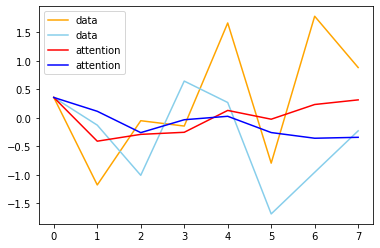

In [29]:
plt.plot(x[0,:,0], label='data', color='orange')
plt.plot(x[0,:,1], label='data', color='skyblue')

avgs = []
for i in range(1, len(x[0])+1):
    avgs.append(x[0,:i].mean(0))
avgs = torch.stack(avgs)

plt.plot(avgs[:,0], label='attention', color='red')
plt.plot(avgs[:,1], label='attention', color='blue')
plt.legend()
plt.show()

the mathmatical trick for averaging from the very first to currnet time step, is a matrix multiplication

In [30]:
# lets say there is a sequence lengh of 3, channel size of 2

trick = torch.ones(3, 3)
x = torch.randint(0, 10, (3, 2)).float()

trick, x, trick @ x

(tensor([[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]),
 tensor([[2., 4.],
         [1., 6.],
         [4., 9.]]),
 tensor([[ 7., 19.],
         [ 7., 19.],
         [ 7., 19.]]))

In [31]:
trick = torch.ones(3, 3).tril()

trick, x, trick @ x

(tensor([[1., 0., 0.],
         [1., 1., 0.],
         [1., 1., 1.]]),
 tensor([[2., 4.],
         [1., 6.],
         [4., 9.]]),
 tensor([[ 2.,  4.],
         [ 3., 10.],
         [ 7., 19.]]))

In [32]:
trick = torch.ones(3, 3).tril()
trick /= trick.sum(dim=1, keepdim=True)
trick

trick, x, trick @ x # average!

(tensor([[1.0000, 0.0000, 0.0000],
         [0.5000, 0.5000, 0.0000],
         [0.3333, 0.3333, 0.3333]]),
 tensor([[2., 4.],
         [1., 6.],
         [4., 9.]]),
 tensor([[2.0000, 4.0000],
         [1.5000, 5.0000],
         [2.3333, 6.3333]]))

let's try this on a batch!

In [37]:
B, T, C = 4, 8, 2 # batch, time, channel
x = torch.randn(B, T, C)
x.shape

torch.Size([4, 8, 2])

In [38]:
trick = torch.ones(T, T).tril()
trick /= trick.sum(dim=1, keepdim=True)
attention = trick
attention

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

we end up using attention mechanism in a transformer which is softmaxed value of importance.

- value at attention[0,:1] is the attention value for a sequence, length of 1 to predict the next value (position 2)
- value at attention[1,:2] is the attention value for a sequence, length of 2 to predict the next value (position 3)
- ...
- value at attention[T,:T] is the attention value for a sequence, length of T to predict the next value (position T+1)

the attention value is a likelihood of importance!
and we are never looking back

another way to create a attention value (which can be similar to transformer's attention (logit) value just before softmax)

In [39]:
logits_just_before_attention = torch.randn(T, T).fill_(-torch.inf).triu(1)
print(logits_just_before_attention)

attention = logits_just_before_attention.softmax(1)
attention

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

In [42]:
attention.shape, x.shape, (attention @ x).shape

print(f"{attention.shape     = }")
print(f"{x.shape             = }")
print(f"{(attention@x).shape = }")

attention.shape     = torch.Size([8, 8])
x.shape             = torch.Size([4, 8, 2])
(attention@x).shape = torch.Size([4, 8, 2])
